In [ ]:
# Solo en google colab
#Cambia el entorno de ejecución a TPU

In [1]:
# Solo en google colab
# Instalar tensorflow_addons
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as plt
import seaborn as sns
sns.set(style="darkgrid")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from google.colab import files
uploaded = files.upload()

Saving DDF.csv to DDF.csv


In [70]:
import io
ddf = pd.read_csv(io.BytesIO(uploaded['DDF.csv']), sep='|')
# Dataset is now stored in a Pandas Dataframe

In [71]:
ddf.head()

,monto,es_fraude,balance_prev_or,balance_prev_des,hora,tipo_binario
0,181.00,1,181.0,0.0,7,1
1,181.00,1,181.0,21182.0,7,0
2,229133.94,0,15325.0,5083.0,7,0
3,215310.30,0,705.0,22425.0,7,1
4,311685.89,0,10835.0,6267.0,7,1


In [72]:
ddf.shape

(2770360, 6)

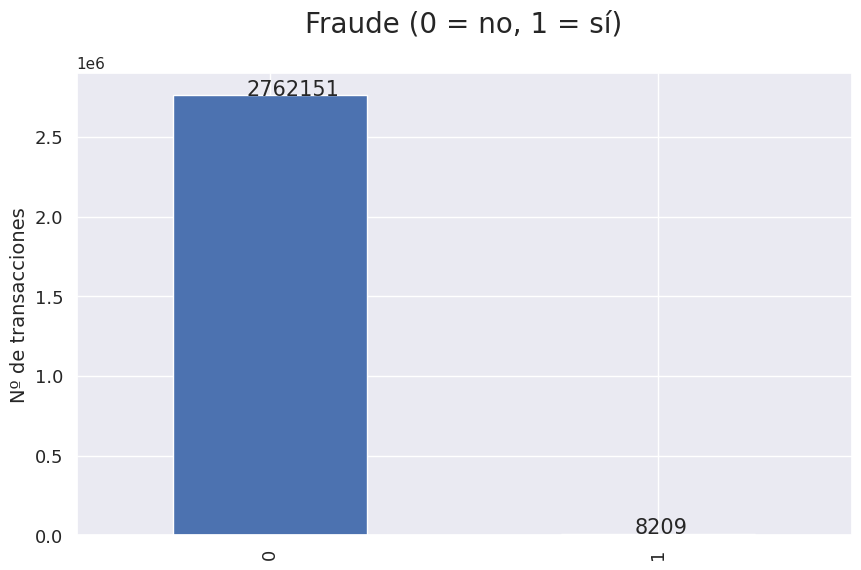

In [73]:
ax = ddf['es_fraude'].value_counts().plot(kind='bar', figsize=(10,6), fontsize=13)
ax.set_title('Fraude (0 = no, 1 = sí)', size=20, pad=30)
ax.set_ylabel('Nº de transacciones', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(),2)), fontsize=15)

In [74]:
X = ddf[['monto','balance_prev_or','balance_prev_des', 'hora','tipo_binario']]
y = ddf[['es_fraude']]

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(14,12)})

# Para suprimir los warnings de scikitlearn por convergencia prematura
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.preprocessing import RobustScaler

In [76]:
X.head()

,monto,balance_prev_or,balance_prev_des,hora,tipo_binario
0,181.00,181.0,0.0,7,1
1,181.00,181.0,21182.0,7,0
2,229133.94,15325.0,5083.0,7,0
3,215310.30,705.0,22425.0,7,1
4,311685.89,10835.0,6267.0,7,1


In [77]:
y.value_counts()

es_fraude
0            2762151
1               8209
dtype: int64

In [78]:
from imblearn.over_sampling import SMOTE
'''generar muestras sintéticas adicionales de la clase minoritaria para equilibrar la distribución de clases en
el conjunto de datos.'''
smote = SMOTE(sampling_strategy='minority')
'''actualiza X e y con las muestras sintéticas generadas para abordar el problema de desequilibrio de clases en el
conjunto de datos.'''
X, y = smote.fit_resample(X, y)

In [79]:
y.value_counts()

es_fraude
0            2762151
1            2762151
dtype: int64

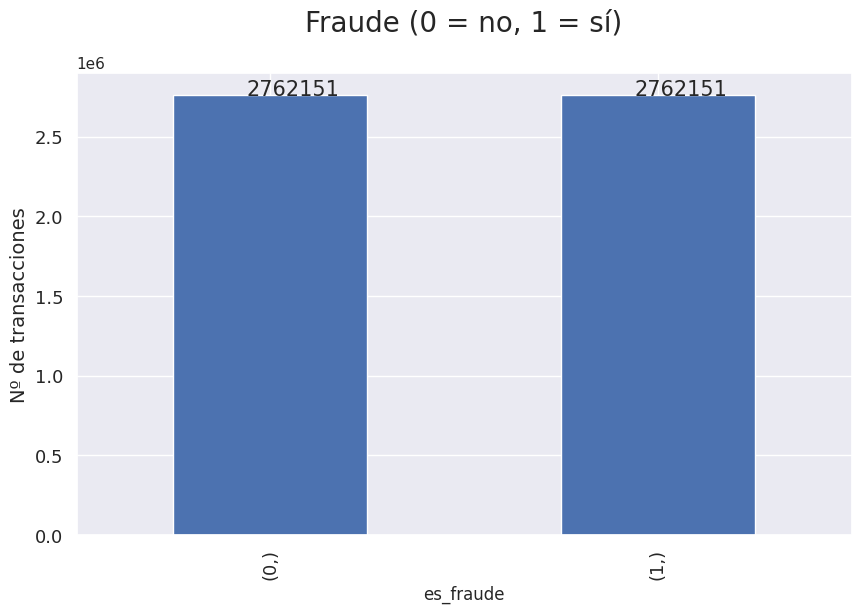

In [80]:
ax = y.value_counts().plot(kind='bar', figsize=(10,6), fontsize=13)
ax.set_title('Fraude (0 = no, 1 = sí)', size=20, pad=30)
ax.set_ylabel('Nº de transacciones', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(),2)), fontsize=15)

In [81]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3867011, 5)
(3867011, 1)
(1657291, 5)
(1657291, 1)


In [82]:
from sklearn.preprocessing import RobustScaler

# Normalizar los datos
scaler = RobustScaler()  # Definir el modelo de normalización
X_train = pd.DataFrame(scaler.fit_transform(X_train))  # Entrenar y normalizar los datos de entrenamiento, ajustamos parámetros
X_test = pd.DataFrame(scaler.transform(X_test))  # Normalizar los datos de prueba

# Comprobar el resultado de la normalización
result = pd.concat([X_train.median(), X_test.median(),
                    (X_train.quantile(0.75) - X_train.quantile(0.25)),
                    (X_test.quantile(0.75) - X_test.quantile(0.25))],
                   axis=1,
                   keys=["Train median", "Test median", "Train iqr", "Test iqr"])
print(result)


   Train median  Test median  Train iqr  Test iqr
0           0.0     0.001100        1.0  1.005139
1           0.0     0.000760        1.0  1.006873
2           0.0    -0.000568        1.0  1.001803
3           0.0     0.000000        1.0  1.000000
4           0.0     0.000000        1.0  1.000000


In [83]:
X_train.shape

(3867011, 5)

In [92]:
# CREACIÓN DEL MODELO
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation=tf.nn.tanh),
    #keras.layers.Dropout(0.15),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
 ])

# model.summary()

In [93]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                384       
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_16 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,537
Trainable params: 17,281
Non-trainable params: 256
_______________________________________________

In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy','Recall','Precision'])

In [95]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.2)

Epoch 1/3
96676/96676 [==============================] - 316s 3ms/step - loss: 0.0837 - accuracy: 0.9688 - recall: 0.9719 - precision: 0.9658 - val_loss: 0.0778 - val_accuracy: 0.9718 - val_recall: 0.9652 - val_precision: 0.9782
Epoch 2/3
96676/96676 [==============================] - 331s 3ms/step - loss: 0.0767 - accuracy: 0.9723 - recall: 0.9752 - precision: 0.9695 - val_loss: 0.0717 - val_accuracy: 0.9775 - val_recall: 0.9825 - val_precision: 0.9729
Epoch 3/3
96676/96676 [==============================] - 325s 3ms/step - loss: 0.0770 - accuracy: 0.9722 - recall: 0.9746 - precision: 0.9699 - val_loss: 0.0692 - val_accuracy: 0.9741 - val_recall: 0.9814 - val_precision: 0.9674


In [96]:
model.evaluate(X_test, y_test)

51791/51791 [==============================] - 104s 2ms/step - loss: 0.0687 - accuracy: 0.9743 - recall: 0.9813 - precision: 0.9678


[0.06874208897352219,
 0.9743243455886841,
 0.9813252091407776,
 0.9678197503089905]

In [ ]:
# precision = precision_score(y_test, y_est)

Accuracy Train: 0.97
Accuracy Test: 0.97


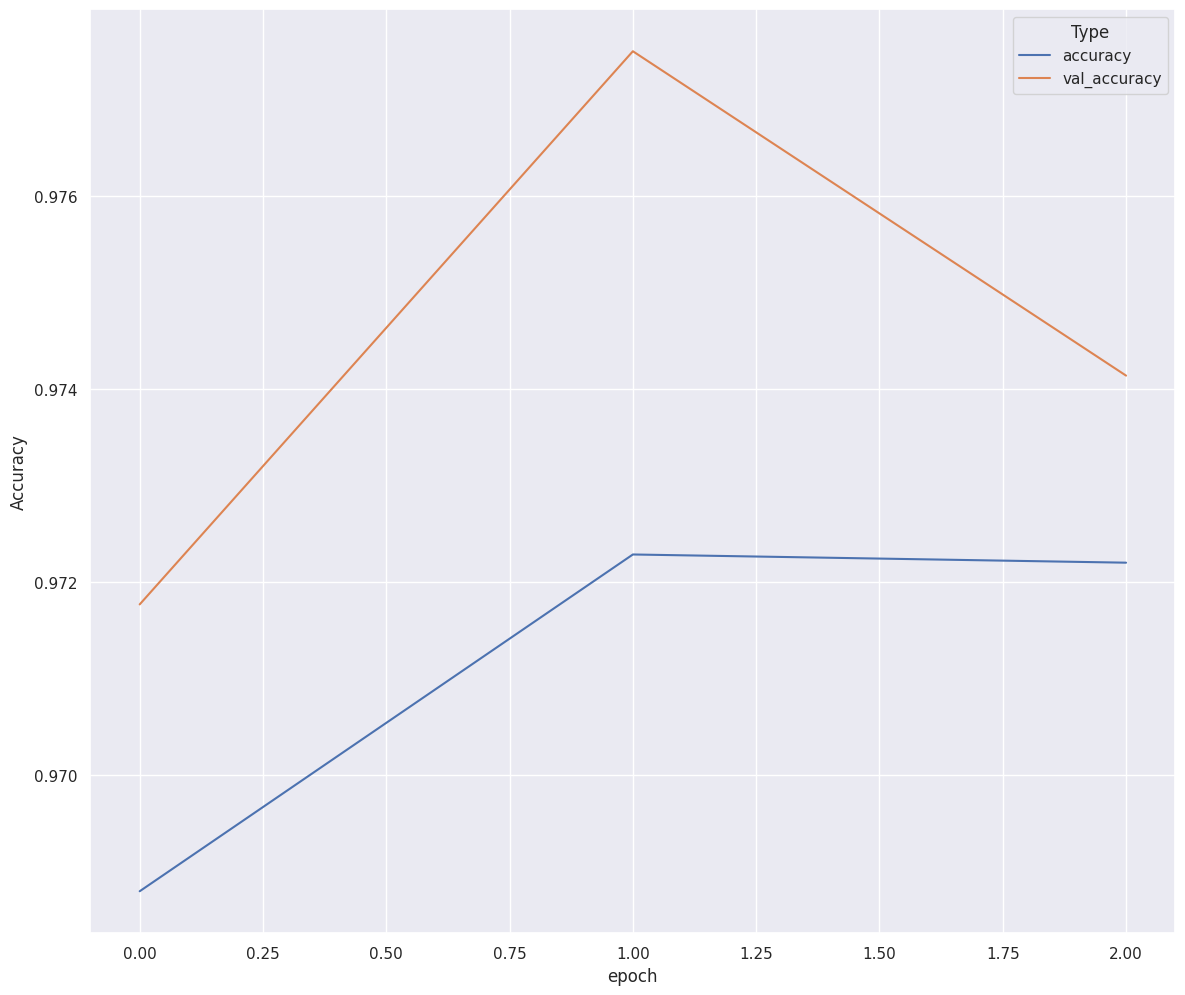

In [97]:
hist = pd.DataFrame(history.history)
# Incluye la epoca para cada error
hist['epoch'] = history.epoch

# Colpasa los errores 'mean_absolute_error','val_mean_absolute_error' en una sola columna para sns
df = hist.melt(id_vars='epoch', var_name='Type', value_name='Accuracy',
               value_vars=['accuracy','val_accuracy'])
# Plot the responses for different events and regions
_ = sns.lineplot(x='epoch', y='Accuracy', hue='Type', data=df)

print("Accuracy Train: %.2f" % model.evaluate(X_train, y_train, verbose=0)[1])
print("Accuracy Test: %.2f" % model.evaluate(X_test, y_test, verbose=0)[1])